### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path



In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/****'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/****' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['test_functions.ipynb', '.DS_Store', 'Code', 'CW_Dataset', 'Video', 'Models']


### Load packages 

In [ ]:
from skimage import io, color, img_as_ubyte, transform
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from joblib import dump, load
from random import randint
from skimage.feature import hog
import cv2
import matplotlib
from matplotlib import rc
import matplotlib.animation as animation
from matplotlib import patches

### Load models

In [ ]:
# to load CNN
# re-initializing CNN class to load saved parameters
kernel_size = 5
# calculating image dimension with different kernel sizes
image_dimension = math.floor((math.floor((math.floor((100 - (kernel_size - 1))/2) - (kernel_size - 1))/2) - (kernel_size - 1))/2)
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(3, 6, kernel_size) # 3 colour channels
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, kernel_size)
      self.conv3 = nn.Conv2d(16, 20, kernel_size)
      self.fc1 = nn.Linear(20 * image_dimension * image_dimension, 120) # 9x9 as that will be the resulting image dimension
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 7) # 7 classes

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = x.reshape(-1, 20 * image_dimension * image_dimension) # changed to x.reshape() from x.view()
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
hog_mlp = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','hog_mlp.joblib')) # loading mlp 
hog_svm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','hog_svm.joblib')) # loading svm
cnn_params = torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','cnn.pth'), map_location=torch.device('cpu')) # loading cnn weights and parameters
cnn = Net() # initialising cnn
cnn.load_state_dict(cnn_params) # loading saved parameters

<All keys matched successfully>

# Test EmotionRecognition

In [ ]:
emotion_dict = {1: "Surprise", 2: "Fear", 3: "Disgust", 4: "Happiness", 5: "Sadness", 6: "Anger", 7: "Neutral"}

def EmotionRecognition(path_to_testset, model_type):
  
  ########################################
  # loading dataset                      #
  ########################################
  # reading images
  images = []
  filenames = [file for file in sorted(os.listdir(path_to_testset)) if file.endswith('.jpg')] # get a list of filenames
  for file in filenames: # iterate over each filename and read the image and append onto list
    images.append(io.imread(os.path.join(path_to_testset, file)))
  
  # getting labels
  path_label = os.path.join(path_to_testset, "list_label_test.txt")
  f = open(path_label, "r")
  labels = [int(entry[-2:]) for entry in f] # get only the label from each line in the text file
  
  #####################
  # sampling 4 images #
  #####################
  sample_index = []
  for i in range(4):
    sample_index.append(randint(0, len(images)-1))
  image_samples = np.asarray(images)[sample_index]
  label_samples = np.asarray(labels)[sample_index]

  if model_type == cnn:
    ####################
    # formatting input #
    ####################
    image_tensor = torch.permute(torch.tensor(image_samples), (0, 3, 1, 2)).float()

    ########################################
    # getting model prediction             #
    ########################################
    model_type.eval() # evaluation mode
    cnn_outputs = model_type(image_tensor) 
    _, cnn_pred = torch.max(cnn_outputs, 1) # argmax
    pred_output = cnn_pred.numpy() + 1 # converting to array and +1 to account for classes starting at 0 with cnn 
  
  else:
    #########################################
    # getting hog descriptors (for non CNN) #
    #########################################
    HOG_des_train = [] # storing feature descriptors in a list

    # iterating over each image in our training set
    for image in images:
      HOG_des = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=False, multichannel=True)
      HOG_des_train.append(HOG_des) # storing descriptors in list
    
    HOG_des_train_array = np.asarray(HOG_des_train) # changing list to array

    ############################
    # getting model prediction #
    ############################
    pred_output = model_type.predict(HOG_des_train_array)

  #########################################
  # plotting results                      #
  #########################################
  fig, ax = plt.subplots(ncols=4, figsize=(18, 6))
  for i in range(4):
    true_label = emotion_dict[label_samples[i]] # getting true label
    pred_label = emotion_dict[pred_output[i]] # getting predicted label
    ax[i].imshow(image_samples[i]) # displaying image
    ax[i].axis('off')
    if true_label == pred_label:
      ax[i].set_title("Label: {0}\nPredict: {1}".format(true_label, pred_label), c="g", fontweight="bold")
    else:
      ax[i].set_title("Label: {0}\nPredict: {1}".format(true_label, pred_label), c="r", fontweight="bold")
  fig.tight_layout()
  plt.show()

Testing Model Over Small Sample

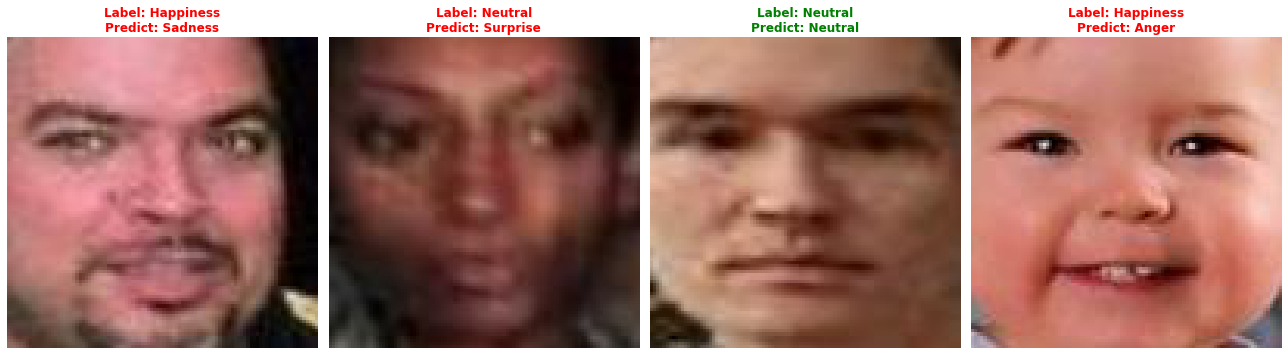

In [ ]:
path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test')
EmotionRecognition(path_to_testset, hog_svm)

# Test EmotionRecognitionVideo

In [ ]:
emotion_dict = {1: "Surprise", 2: "Fear", 3: "Disgust", 4: "Happiness", 5: "Sadness", 6: "Anger", 7: "Neutral"}
matplotlib.rcParams['animation.embed_limit'] = 2**128

def EmotionRecognitionVideo(video_name):

  ########################################
  # loading video                        #
  ########################################

  # get video path and load video
  video_path = os.path.join(GOOGLE_DRIVE_PATH, 'Video', video_name)
  cap = cv2.VideoCapture(video_path)

  # get frame count, frame width and frame height from our loaded video
  frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # create a 4 dimensional array (frame count, frame height, frame width, and colour channels) to store our video
  video = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

  fc = 0
  ret = True
  # store our frames in video array
  while fc < frameCount and ret:
    ret, video[fc] = cap.read() # read until no frames to grab
    video[fc] = cv2.cvtColor(video[fc], cv2.COLOR_BGR2RGB) # convert colour channels from BGR to RGB
    fc += 1

  # to close video file
  cap.release()

  #############################################
  # face detection algorithm                  #
  #############################################

  # defining how often we want to detect a face and emotion
  frame_interval = 10

  # load haarcascade_frontalface_defaul.xml model from data.haarcascades (pre-trained)
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  # to store patches that encloses the face
  face_array = np.empty((math.floor(video.shape[0]/frame_interval) + 1, 4)) # each entry corresponds to a frame with (x, y, width, height)

  # to store cut-out of detected face
  cutout_array = np.empty((math.floor(video.shape[0]/frame_interval) + 1, 100, 100, 3))

  # to store ending x and y coordinates of boxes
  end_x_list = []
  end_y_list = []

  # iterate over each frame and detect faces if any
  for frame in range(video.shape[0]):
    if frame % frame_interval == 0: # record emotion every 10th frame

      # formatting each frame 
      img = video[frame, :, :, :] # get each frame
      img_gray = color.rgb2gray(img) # converting from rgb to gray
      img_gray = img_as_ubyte(img_gray)

      # detect face from each frame
      faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
      face_array[math.floor(frame/frame_interval)] = faces # store coordinates 

      # cutout detected face from video frame 
      # get coordinates of detected face (rectangle)
      start_x = int(faces[0][0])
      start_y = int(faces[0][1])
      end_x = int(faces[0][0] + faces[0][2])
      end_y = int(faces[0][1] + faces[0][3])
      end_x_list.append(end_x)
      end_y_list.append(end_y)
      
      # cutout from video frame and rescale it to 100x100x3 so that it can be parsed through the model
      face_cutout = video[frame, start_y:end_y, start_x:end_x, :]
      face_cutout_formatted = img_as_ubyte(transform.rescale(face_cutout, (100/face_cutout.shape[0], 100/face_cutout.shape[1]), 
                                                            multichannel=True, anti_aliasing=True))
      cutout_array[math.floor(frame/frame_interval)] = face_cutout_formatted

  #########################
  # parsing through model #
  #########################
  
  # getting feature descriptors from cutouts
  HOG_des_list = [] # storing feature descriptors in a list

  # iterating over each cutout
  for cutout in cutout_array:
    HOG_des = hog(cutout, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=False, multichannel=True)
    HOG_des_list.append(HOG_des) # storing descriptors in list
  HOG_des_array = np.asarray(HOG_des_list) # changing list to array

  # getting predicted classes 
  pred_values = hog_svm.predict(HOG_des_array) # get predicted class
  pred_labels = [emotion_dict[pred] for pred in pred_values] # mapping over class to label

  ########################################
  # displaying video                     #
  ########################################

  rc('animation', html='jshtml')
  fig, ax = plt.subplots()

  # call to next frame where we display the video frame, plot the patch surrounding the detected face and the predicted emotion
  def frame(i):
      ax.clear()
      ax.axis('off')
      # keep the patch and previous label on for 5 frames
      if i % frame_interval < math.floor(frame_interval) + 1:
        ax.add_patch(patches.Rectangle(xy=(face_array[math.floor(i/frame_interval), 0], face_array[math.floor(i/frame_interval), 1]), 
                                width=face_array[math.floor(i/frame_interval), 2], height=face_array[math.floor(i/frame_interval), 3], 
                                fill=False, color='r', linewidth=2))
        ax.text(end_x_list[math.floor(i/frame_interval)], end_y_list[math.floor(i/frame_interval)] + 10, pred_labels[math.floor(i/frame_interval)], 
                color='r', fontweight="bold")
      # elif i % 10 < 6:
      #   ax.text(end_x_list[math.floor(i/10)], end_y_list[math.floor(i/10)] + 10, pred_labels[math.floor(i/10)], color='r', fontweight="bold")
      fig.tight_layout()
      plot=ax.imshow(video[i, :, :, :])
      return plot

  # frame calls the next frame, for x number of frames
  # anim = animation.FuncAnimation(fig, frame, frames=video.shape[0], interval=50)
  anim = animation.FuncAnimation(fig, frame, frames=100, interval=50)
  plt.close()
  plt.show()

  return anim

Then, make a call to the `EmotionRecognitionVideo` function to see what results it produces.

In [ ]:
TERV = EmotionRecognitionVideo('terv_edit_8x.mp4')
TERV

Output hidden; open in https://colab.research.google.com to view.